In [247]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [248]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [249]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [250]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [251]:
train_delta_t = 0
max_depth = 4
eval_metric = 'rmse'
n_estimators = 10000
scaler_name = 'MinMaxScaler'
scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()
random_state = 37
submission_path = '8_nov_sub/'

In [252]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [253]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [254]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [255]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [256]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [257]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

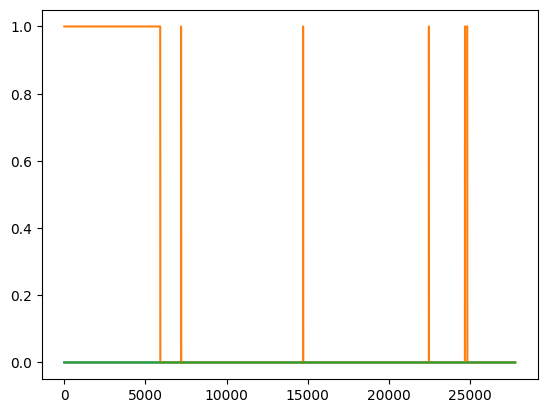

In [258]:
plt.plot(train_c.isna())

In [259]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [260]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [261]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [262]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [263]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [264]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [265]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [266]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [267]:
start_2019 = pd.to_datetime("2019-03-21")
end_2019 = pd.to_datetime("2019-09-22")

start_2020 = pd.to_datetime("2020-03-21")
end_2020 = pd.to_datetime("2020-09-22")

start_2021 = pd.to_datetime("2021-03-21")
end_2021 = pd.to_datetime("2021-09-22")

start_2022 = pd.to_datetime("2022-03-21")
end_2022 = pd.to_datetime("2022-09-22")

In [268]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [269]:
def split_training_testing_set(df, start_estimated, random_state=42, text_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]

    test_size = text_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    # train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    unique_dates = df_summers[time_column].dt.date.unique()

    train_dates, test_dates = train_test_split(unique_dates, test_size=test_size, random_state=random_state)

    train_data_summer = df_summers[df_summers[time_column].dt.date.isin(train_dates)]
    pv_test_not_ordered = df_summers[df_summers[time_column].dt.date.isin(test_dates)]

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by=time_column)
    pv_test = pv_test_not_ordered.sort_values(by=time_column)
    return pv_train, pv_test

In [270]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [271]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100, '%')
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100, '%')
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100, '%')

train_a : (30635, 47)
test_a : (3410, 47)
Rapport test/total : 10.0 %
train_b : (24436, 47)
test_b : (2727, 47)
Rapport test/total : 10.0 %
train_c : (19494, 47)
test_c : (2208, 47)
Rapport test/total : 10.2 %


## Changement type de la date_forecast

In [272]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [273]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [274]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [275]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.fit_transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [276]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [277]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [278]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [279]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:864.65608	validation_1-rmse:1119.82861
[1]	validation_0-rmse:694.56868	validation_1-rmse:896.20729
[2]	validation_0-rmse:588.94558	validation_1-rmse:760.61204
[3]	validation_0-rmse:524.23744	validation_1-rmse:688.14229
[4]	validation_0-rmse:485.84216	validation_1-rmse:649.57267
[5]	validation_0-rmse:464.00433	validation_1-rmse:627.51499
[6]	validation_0-rmse:449.06330	validation_1-rmse:612.82554
[7]	validation_0-rmse:439.00434	validation_1-rmse:602.02375
[8]	validation_0-rmse:432.70133	validation_1-rmse:595.57214
[9]	validation_0-rmse:426.77783	validation_1-rmse:590.15444
[10]	validation_0-rmse:423.20322	validation_1-rmse:584.72433
[11]	validation_0-rmse:420.24804	validation_1-rmse:582.17181
[12]	validation_0-rmse:417.55102	validation_1-rmse:579.01580
[13]	validation_0-rmse:415.18910	validation_1-rmse:577.31362
[14]	validation_0-rmse:413.19628	validation_1-rmse:576.26689
[15]	validation_0-rmse:411.20681	validation_1-rmse:575.70605
[16]	validation_0-rmse:409.51802	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:353.15286	validation_1-rmse:593.63530
[61]	validation_0-rmse:351.48122	validation_1-rmse:594.24600
[62]	validation_0-rmse:350.70109	validation_1-rmse:594.46464
[63]	validation_0-rmse:350.33580	validation_1-rmse:595.23524
[64]	validation_0-rmse:349.58080	validation_1-rmse:594.94012
[65]	validation_0-rmse:348.73082	validation_1-rmse:595.39867
[0]	validation_0-rmse:151.26428	validation_1-rmse:212.90963
[1]	validation_0-rmse:119.46267	validation_1-rmse:168.53172
[2]	validation_0-rmse:99.05501	validation_1-rmse:142.08330
[3]	validation_0-rmse:86.05682	validation_1-rmse:125.73086
[4]	validation_0-rmse:78.33427	validation_1-rmse:114.81175
[5]	validation_0-rmse:73.93830	validation_1-rmse:110.61052
[6]	validation_0-rmse:70.88103	validation_1-rmse:110.01259
[7]	validation_0-rmse:68.76543	validation_1-rmse:109.93252
[8]	validation_0-rmse:67.20887	validation_1-rmse:107.92080
[9]	validation_0-rmse:66.04909	validation_1-rmse:107.18301
[10]	validation_0-rmse:65.11631	validation

[29]	validation_0-rmse:58.27067	validation_1-rmse:109.87588
[30]	validation_0-rmse:57.86162	validation_1-rmse:110.43387
[31]	validation_0-rmse:57.57125	validation_1-rmse:109.92805
[32]	validation_0-rmse:57.32507	validation_1-rmse:109.68372
[33]	validation_0-rmse:57.02520	validation_1-rmse:110.83124
[34]	validation_0-rmse:56.75096	validation_1-rmse:110.91327
[35]	validation_0-rmse:56.52917	validation_1-rmse:110.91345
[36]	validation_0-rmse:56.14277	validation_1-rmse:110.95305
[37]	validation_0-rmse:55.89547	validation_1-rmse:109.58042
[38]	validation_0-rmse:55.70660	validation_1-rmse:109.98956
[39]	validation_0-rmse:55.36536	validation_1-rmse:109.82540
[40]	validation_0-rmse:55.04577	validation_1-rmse:109.62057
[41]	validation_0-rmse:54.90311	validation_1-rmse:109.75574
[42]	validation_0-rmse:54.65601	validation_1-rmse:109.78111
[43]	validation_0-rmse:54.59260	validation_1-rmse:110.05872
[44]	validation_0-rmse:54.35904	validation_1-rmse:109.65600


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:54.23723	validation_1-rmse:110.05406
[46]	validation_0-rmse:53.94564	validation_1-rmse:110.52654
[47]	validation_0-rmse:53.69573	validation_1-rmse:110.34523
[48]	validation_0-rmse:53.34349	validation_1-rmse:110.53025
[49]	validation_0-rmse:52.95367	validation_1-rmse:110.32368
[50]	validation_0-rmse:52.66134	validation_1-rmse:110.17123
[51]	validation_0-rmse:52.51974	validation_1-rmse:109.51192
[52]	validation_0-rmse:52.45791	validation_1-rmse:109.48082
[53]	validation_0-rmse:52.38972	validation_1-rmse:109.49337
[54]	validation_0-rmse:52.23297	validation_1-rmse:109.43590
[55]	validation_0-rmse:52.12529	validation_1-rmse:109.49764
[56]	validation_0-rmse:51.94383	validation_1-rmse:109.52021
[57]	validation_0-rmse:51.62196	validation_1-rmse:109.32717
[58]	validation_0-rmse:51.41287	validation_1-rmse:109.70407
[59]	validation_0-rmse:51.14899	validation_1-rmse:109.38469
[60]	validation_0-rmse:50.93023	validation_1-rmse:109.42693
[61]	validation_0-rmse:50.76382	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

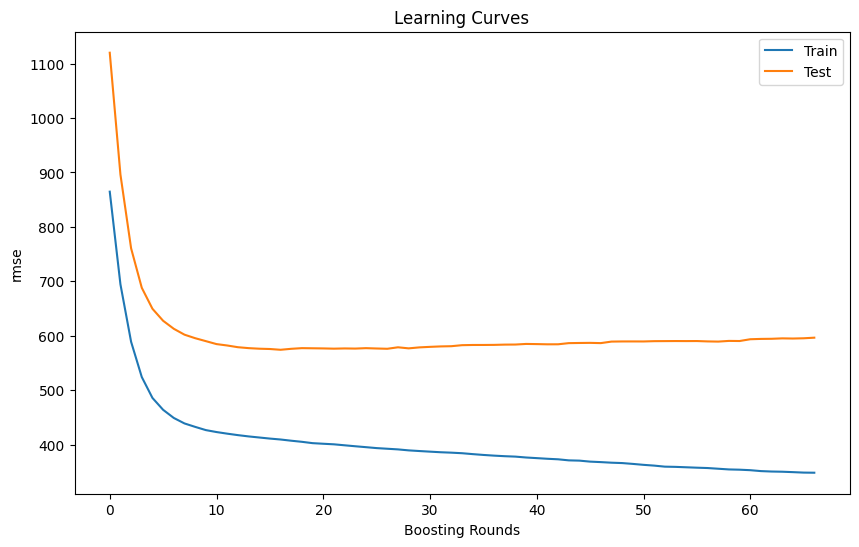

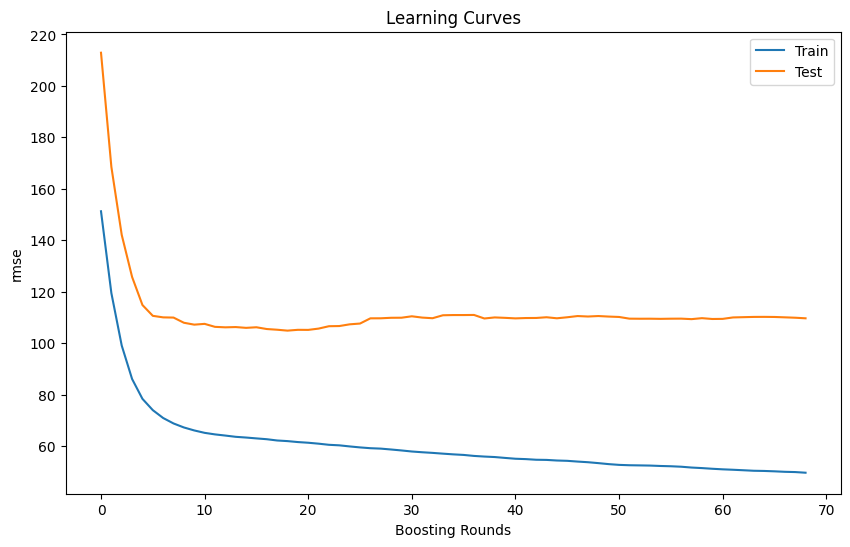

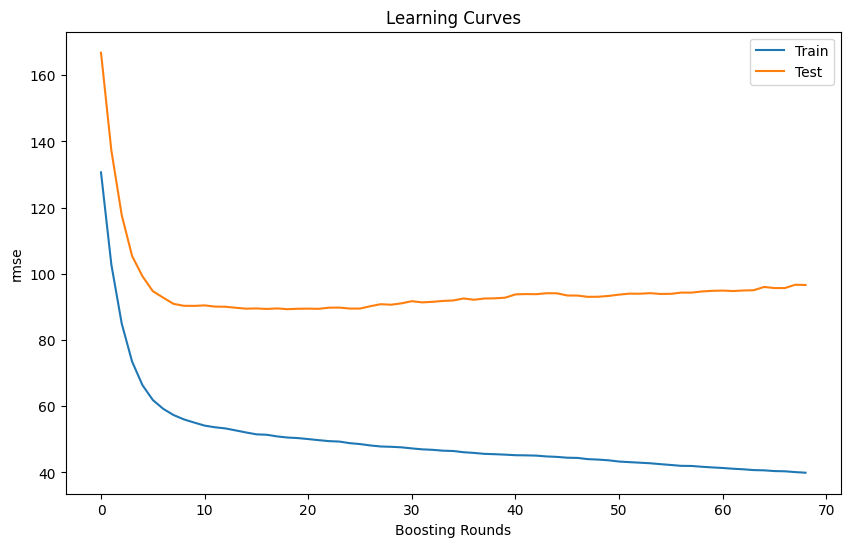

In [280]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [281]:
min_error_a, min_error_b, min_error_c

(574.2855782799955, 104.856056225016, 89.3207971460901)

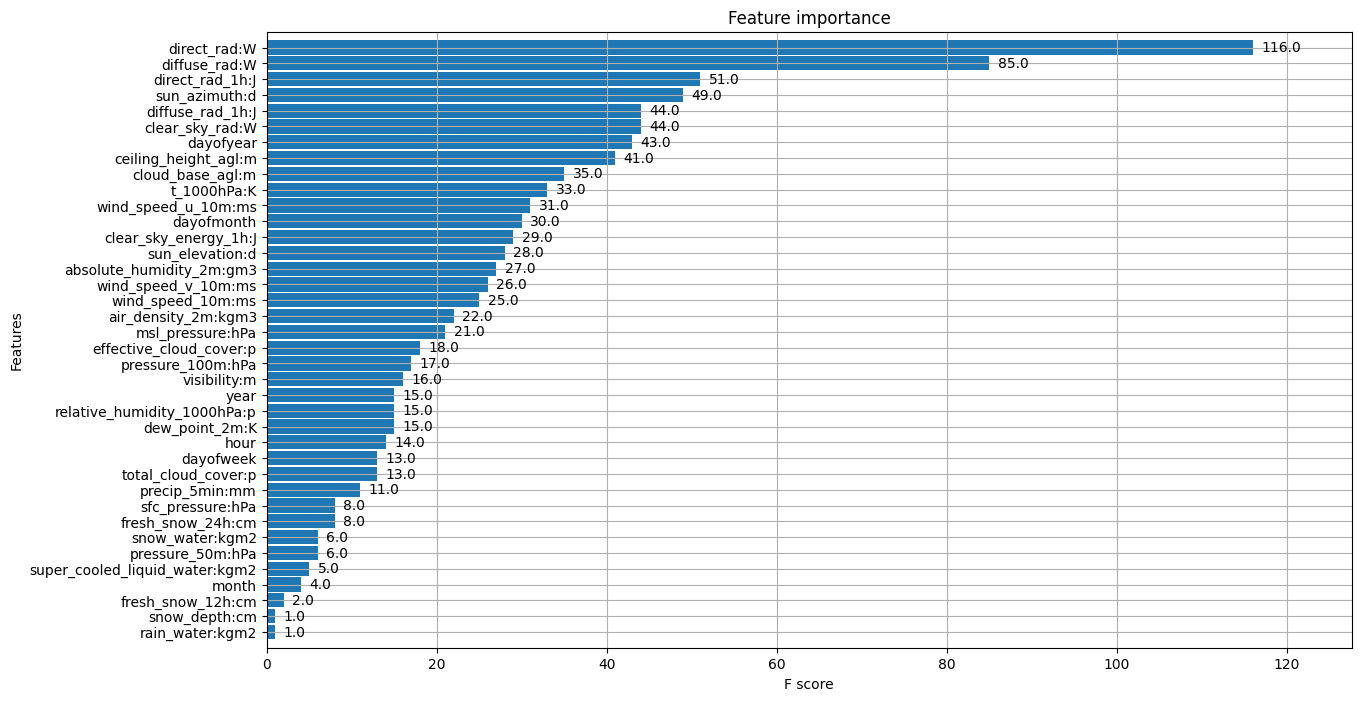

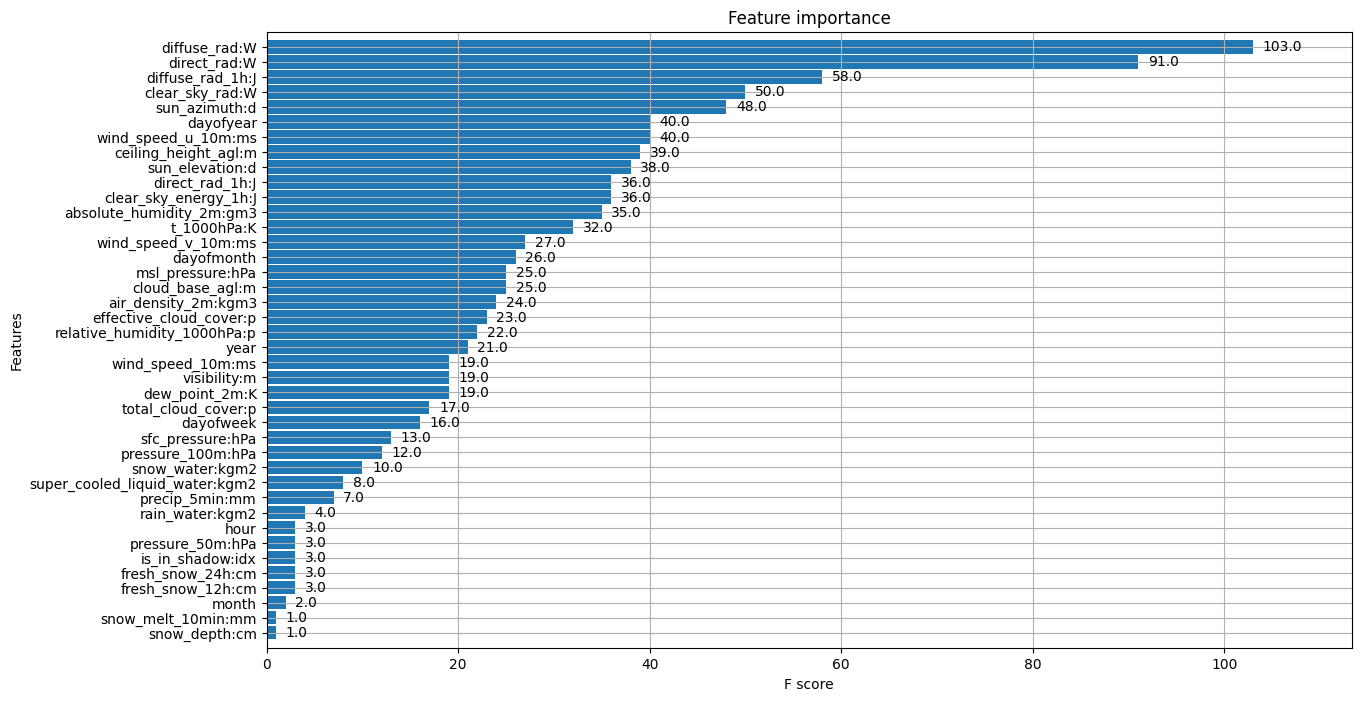

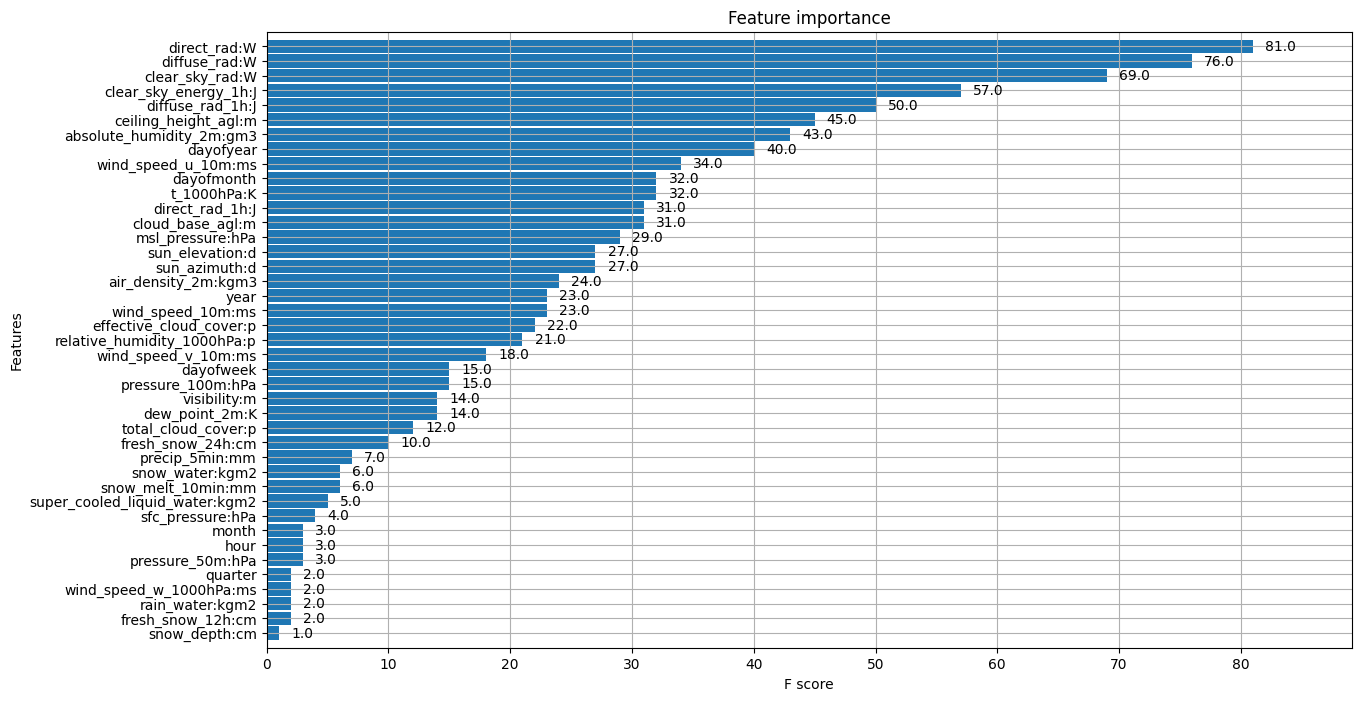

In [282]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [283]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [284]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_50665/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_50665/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_50665/182118369.py:

In [285]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

df_mae = pd.concat([pv_all_a, pv_all_b, pv_all_a])
mae = np.mean(np.abs(df_mae['pv_measurement'] - df_mae['pv_measurement_prediction']))
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 313.10841225945285 MAE b: 57.3185932893258 MAE c: 414.94807085764415
MAE on test set: 240.044744475695


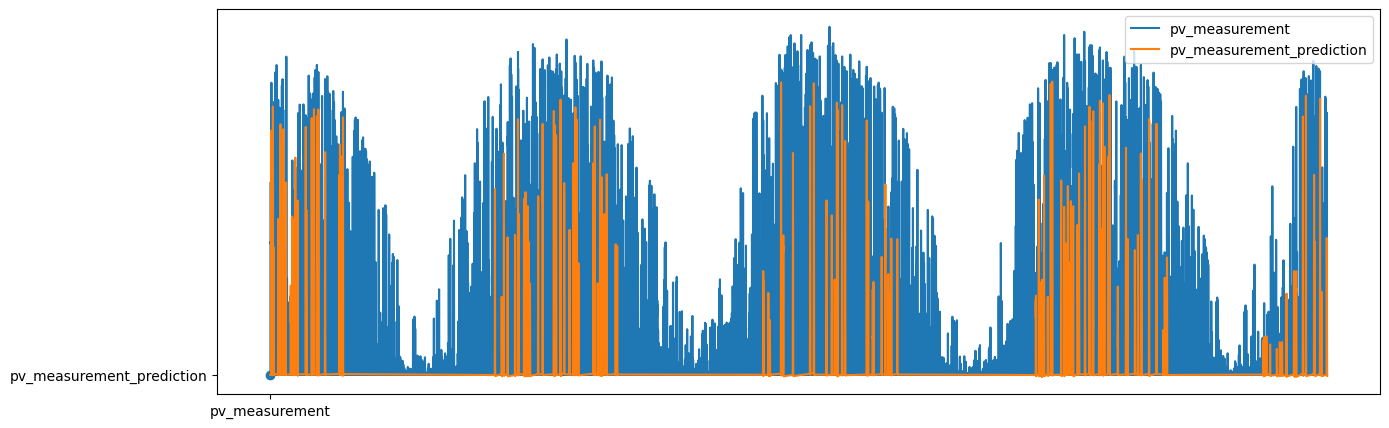

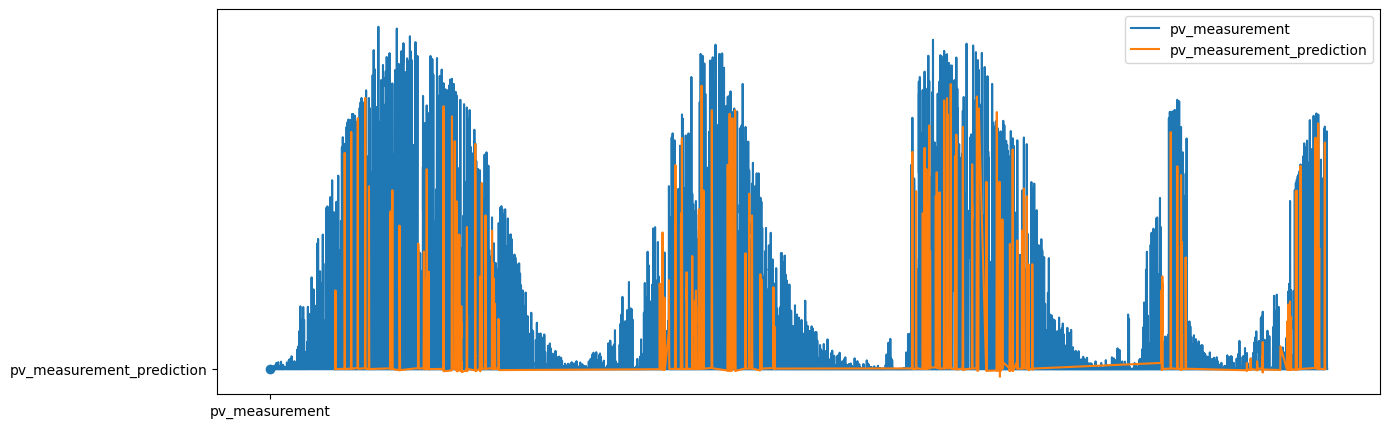

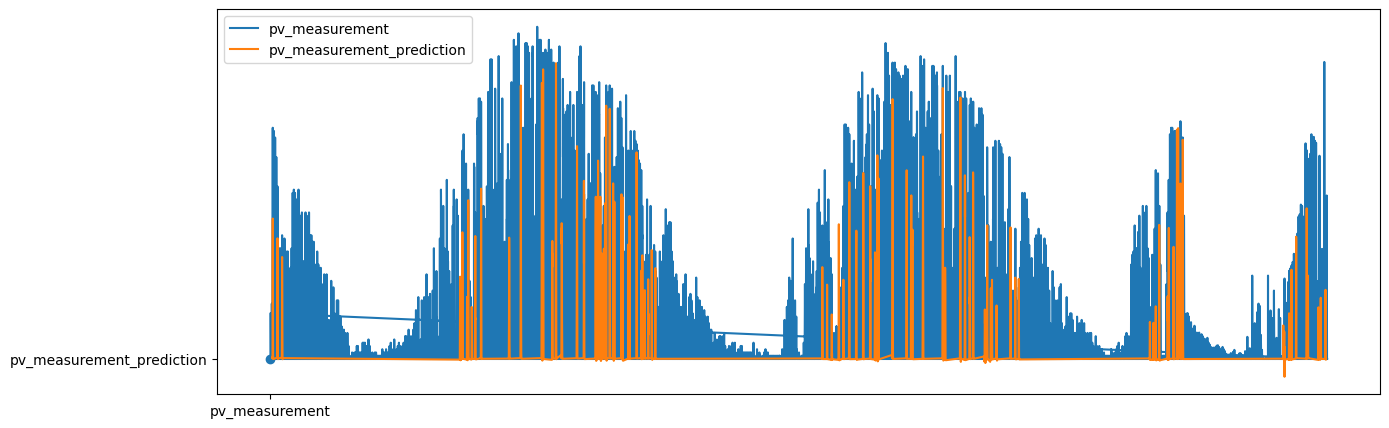

In [286]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

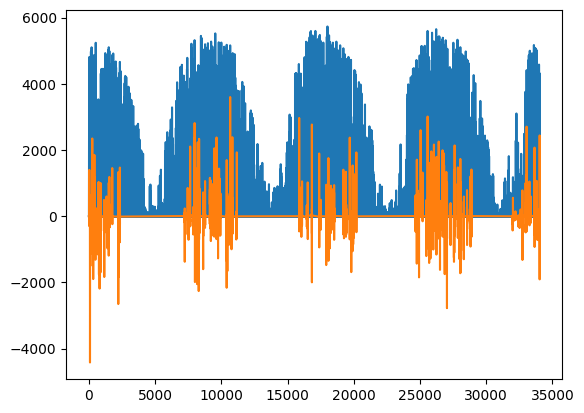

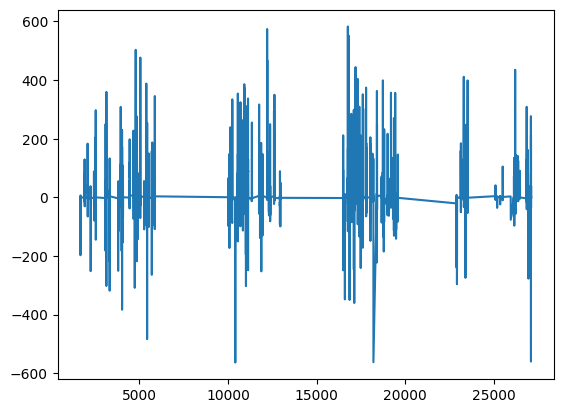

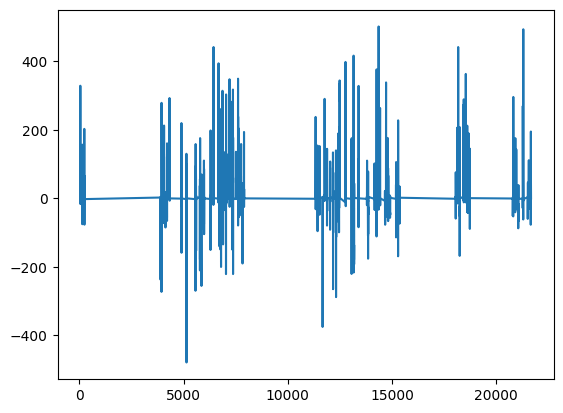

In [287]:
# pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
plt.plot(pv_all_a['pv_measurement'])
plt.plot(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction'])
plt.show()
plt.plot(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction'])
plt.show()
plt.plot(pv_all_c['pv_measurement'] - pv_all_c['pv_measurement_prediction'])
plt.show()


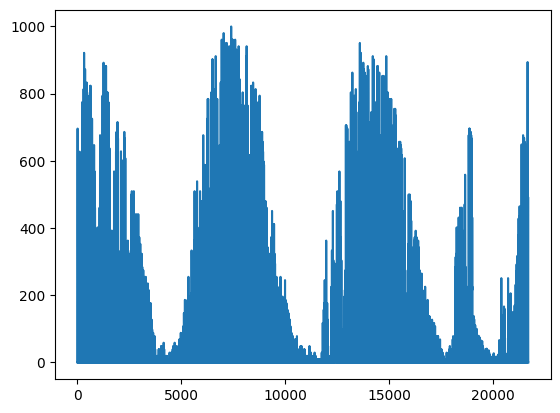

In [288]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [289]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [290]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [291]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [292]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [293]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

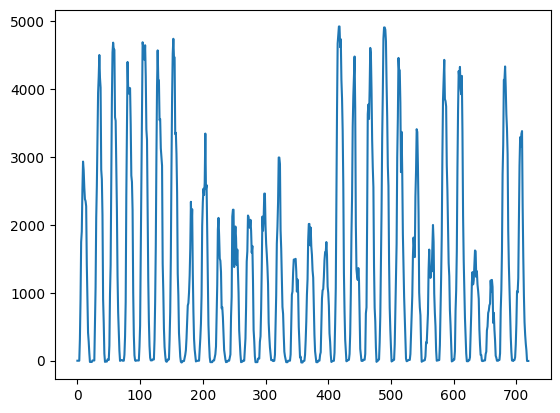

In [294]:
plt.plot(result_A)

In [295]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [296]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

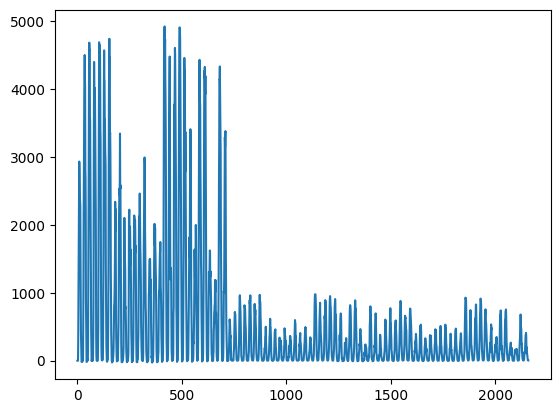

In [297]:
plt.plot(result)

In [298]:
np.argmax(np.array(result))

417

In [299]:
pv_all_a[pv_all_a['pv_measurement']==pv_all_a['pv_measurement'].max()]

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,pv_measurement_prediction
18012,2021-06-22 10:00:00,7.0,1.23,2173.800049,2781782.0,802.599976,1009.5,0.0,279.0,292.299988,1.004267e+06,100.199997,417397.5,88.599998,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1019.200012,0.0,0.0,1006.200012,1012.200012,0.0,0.0,60.099998,1018.299988,0.0,0.0,-0.0,0.0,151.384003,47.726002,0.1,284.200012,96.400002,51089.699219,1.1,0.9,-0.6,-0.0,NaT,5733.42,10,1,2,6,2021,173,22,NaN


In [300]:
X_test_estimated_a

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,0.0,0.0,80.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,1000.700012,1007.000000,0.0,0.0,80.300003,1013.299988,NaN,0.0,0.0,0.0,0.0,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,0.0,0.0,77.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.700012,0.0,0.0,1000.599976,1006.900024,0.0,0.0,80.300003,1013.200012,NaN,0.0,0.0,0.0,0.0,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,0.0,0.0,0.0,0.0,73.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.599976,0.0,0.0,1000.500000,1006.700012,0.0,0.0,80.300003,1013.000000,NaN,0.0,0.0,0.0,0.0,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,0.0,0.0,0.0,0.0,69.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.500000,0.0,0.0,1000.400024,1006.599976,0.0,0.0,80.199997,1012.900024,NaN,0.0,0.0,0.0,0.0,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,0.0,0.0,0.0,0.0,64.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.299988,0.0,0.0,1000.200012,1006.500000,0.0,0.0,80.199997,1012.799988,NaN,0.0,0.0,0.0,0.0,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2023-07-02 07:00:31,2023-07-03 22:45:00,9.1,1.207,2090.600098,0.0,0.0,1629.400024,0.0,282.700012,0.0,0.0,0.0,0.0,99.300003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.299988,0.0,0.0,980.799988,986.700012,0.0,0.0,82.199997,992.599976,NaN,0.0,0.0,-0.0,0.0,351.855988,-3.282,0.1,285.399994,99.400002,39931.601562,2.1,1.7,-1.3,0.0
2876,2023-07-02 07:00:31,2023-07-03 23:00:00,9.1,1.207,2015.800049,0.0,0.0,1537.300049,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.400024,0.0,0.0,980.900024,986.799988,0.0,0.0,82.500000,992.700012,NaN,0.0,0.0,-0.0,0.0,355.317993,-3.469,0.1,285.299988,100.000000,39574.300781,2.0,1.6,-1.3,0.0
2877,2023-07-02 07:00:31,2023-07-03 23:15:00,9.1,1.208,2015.699951,0.0,0.0,1471.400024,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,981.000000,986.900024,0.0,0.0,82.800003,992.799988,NaN,0.0,0.0,-0.0,0.0,358.785004,-3.556,0.1,285.299988,100.000000,39627.199219,2.0,1.6,-1.2,0.0
2878,2023-07-02 07:00:31,2023-07-03 23:30:00,9.0,1.208,2015.599976,0.0,0.0,1405.500000,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.599976,0.0,0.0,981.000000,986.900024,0.0,0.0,83.199997,992.900024,NaN,0.0,0.0,-0.0,0.0,2.253000,-3.541,0.1,285.200012,100.000000,39691.800781,2.0,1.6,-1.1,0.0


In [301]:
X_total_a_y.loc[np.argmax(np.array(y_train_a))], y_train_a.loc[np.argmax(np.array(y_train_a))]

(date_forecast                     2021-04-17 08:00:00
 absolute_humidity_2m:gm3                          4.8
 air_density_2m:kgm3                             1.286
 ceiling_height_agl:m                              NaN
 clear_sky_energy_1h:J                       1366429.5
 clear_sky_rad:W                            439.200012
 cloud_base_agl:m                                  NaN
 dew_or_rime:idx                                   0.0
 dew_point_2m:K                             273.200012
 diffuse_rad:W                               75.699997
 diffuse_rad_1h:J                         260966.90625
 direct_rad:W                               355.399994
 direct_rad_1h:J                            1091909.75
 effective_cloud_cover:p                           1.2
 elevation:m                                       6.0
 fresh_snow_12h:cm                                 0.0
 fresh_snow_1h:cm                                  0.0
 fresh_snow_24h:cm                                 0.0
 fresh_sno

In [302]:
X_test_estimated_a.loc[np.argmax(np.array(result))], result[np.argmax(np.array(result))]

(date_calc                         2023-05-19 07:00:30
 date_forecast                     2023-05-20 08:15:00
 absolute_humidity_2m:gm3                          8.8
 air_density_2m:kgm3                             1.232
 ceiling_height_agl:m                      9364.599609
 clear_sky_energy_1h:J                      2076239.25
 clear_sky_rad:W                            630.900024
 cloud_base_agl:m                          7157.700195
 dew_or_rime:idx                                   0.0
 dew_point_2m:K                             282.399994
 diffuse_rad:W                              101.400002
 diffuse_rad_1h:J                          366628.6875
 direct_rad:W                                    465.5
 direct_rad_1h:J                             1501843.5
 effective_cloud_cover:p                     35.299999
 elevation:m                                       6.0
 fresh_snow_12h:cm                                 0.0
 fresh_snow_1h:cm                                  0.0
 fresh_sno

In [303]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

2.996513243092727

In [304]:
negative_mask = result < 10
result[negative_mask] = 0

In [305]:
nom_fichier = f'XGBoost_separated_loc_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_{eval_metric}_max_depth_{max_depth}_mae_{int(mae)}_rmse_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}_rd_subsets_{random_state}_by_day'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

OSError: Cannot save file into a non-existent directory: '8_nov_sub'

In [ ]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [ ]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0